In [ ]:
#Archangel 0.0.5
#Programa em R rodando no Python com o rpy2

In [2]:
#Importação dos pacotes usados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
from scipy import signal as sg
import winsound
import time
from IPython.display import display
from ipywidgets import widgets
from tkinter import *


#conda install rpy2 #instalador do rpy2. Só precisa rodar uma vez

#Pacotes do R para serem instalados

import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import importr
from rpy2.robjects.functions import SignatureTranslatedFunction
rpy2.robjects.numpy2ri.activate()
R = rpy2.robjects.r
rpy2.robjects.r('install.packages("dtw")')
#rpy2.robjects.r('install.packages("tuneR")')
#rpy2.robjects.r('install.packages("seewave")')
#rpy2.robjects.r('install.packages("signal")')
#rpy2.robjects.r('install.packages("svDialogs")')

rpy2.rinterface.NULL

In [3]:
#função AVB: transforma áudio em matriz de MFCC
rpy2.robjects.r('''

AVB <- function(audio, threshold, T_frame, TA, mode){
  library(tuneR)
  library(seewave)
  library(signal)
  fv_min = 50
  fv_max = 3400
  TA = 8000
  numcep = 5
  MFCC <- list()
  audio_final <- list()
  c = 1
  resto <- length(audio)%%(TA*T_frame)
  zeros <- rep(0,resto)
  audio <- c(audio,zeros)
  frame <- as.data.frame(matrix(audio, ncol = TA*T_frame, byrow = TRUE))
  for(a in 1:nrow(frame)){
    som <- Wave(left = as.numeric(frame[a,]), right = numeric(0), samp.rate = TA, bit = 16, pcm = TRUE)
    som <- bwfilter(som,TA,channel = 1, n = 8, from = fv_min, to = fv_max, bandpass = TRUE, listen = FALSE, output = "Wave")
    audio <- som@left - mean(som@left)
    audio <- audio/max(audio)
    audio <- ifelse(abs(audio) < threshold, 0, audio)
    rle_audio <- rle(audio)
    rle_audio$values[ rle_audio$values==0 & rle_audio$lengths > 100] <- NA
    audio <- inverse.rle(rle_audio)
    audio <- audio[!is.na(audio)]
    som <- Wave(left = audio, right = numeric(0), samp.rate = TA, bit = 16, pcm = TRUE)
    if(length(audio) > TA/2){
      E_mfcc <- melfcc(som, sr = TA, numcep = numcep)
      MFCC[[c]] <- as.vector(t(E_mfcc)) 
      audio_final[[c]] <- som@left
      c = c + 1
    }    
  }
  if(mode == "mfcc"){
      return(MFCC)
  }else{
      return(audio_final)
  }  
}

 ''')
AVB = rpy2.robjects.globalenv['AVB']

In [4]:
#AVB Finder: função que faz o match entre 2 códigos MFCC

def AVB_finder(mfcc, mfcc_cdb, precisao):
    rpy2.robjects.r('''
                    dtw_dist <- function(MFCC1, MFCC2) {
                    library(dtw)
                    return(dtw(MFCC1,MFCC2)$normalizedDistance)
                    }
                    ''')
    DTW = rpy2.robjects.globalenv['dtw_dist']
    resposta = []
    for a in range(len(mfcc)):
        for b in range(len(mfcc_cdb)):
            dist = DTW(mfcc[a],mfcc_cdb[b])
            resposta = np.concatenate((resposta,dist), axis = None)
    #print(resposta)
    if resposta == []:
        return("Não há voz audível")
    elif np.amin(resposta) < precisao:
        return("Usuário identificado", np.amin(resposta))
    else:
        return("Usuário não identificado", np.amin(resposta))

In [5]:
from tkinter import *
AVB_CCB = {} #Este é o dicionário onde estarão todos os mfccs registrados
AVB_CVR = {} #Este é o dicionário onde estarão todas as vozes registradas
AVB_CVG = {} #Este é o dicionário da voz gravada no momento

#Alguns parâmetros

TA = 48000 #Taxa de amostragem
TH = 0.2 #Threshold
TS = 1 #Time Shift em segundo
TR = int(TA*TS*3) #Time Record
precisao = 1.4

#GUI e voz gravada

class Application:
    def __init__(self, master=None):
        
        self.fontePadrao = ("Arial", "12") #define uma fonte padrão
        
        self.C1 = Frame(master)
        #self.C1["pady"] = 20
        self.C1.pack()
        
          
        self.C2 = Frame(master)
        #self.C2["padx"] = 20
        self.C2.pack()
  
        self.C3 = Frame(master)
        #self.C3["pady"] = 10
        self.C3.pack()
  
        self.C31 = Frame(master)
        #self.C31["pady"] = 10
        self.C31.pack()
  
        self.C4 = Frame(master)
        #self.C4["pady"] = 10
        #self.C4["padx"] = 0
        self.C4.pack()
        
        self.C5 = Frame(master)
        #self.C5["pady"] = 10
        #self.C5["padx"] = 0
        self.C5.pack()
                
        #Título  
        self.titulo = Label(self.C1, text="!!!Bem vindo ao sistema Archangel!!!")
        self.titulo["font"] = ("Arial", "15", "bold")
        self.titulo.pack()
        
        #Nome
  
        self.menu = Label(self.C2,text="Nome", font=self.fontePadrao)
        self.menu.pack(side = LEFT)

        #Botões
  
        self.register = Button(self.C3, text = "Cadastrar nova voz", bd = '5', font = self.fontePadrao,
                               command = self.AVB_register)
        self.register.pack(side=LEFT)
        self.finder = Button(self.C3)
        self.finder["text"] = "Encontrar minha voz"
        self.finder["font"] = self.fontePadrao
        self.finder["width"] = 17
        self.finder["command"] = self.AVB_finder
        self.finder.pack(side = LEFT)
        self.finder = Button(self.C3)
        self.finder["text"] = "Ver vozes cadastradas"
        self.finder["font"] = self.fontePadrao
        self.finder["width"] = 17
        self.finder["command"] = self.cadastro
        self.finder.pack(side = LEFT)
        self.finder = Button(self.C31)
        self.finder["text"] = "Ouvir voz registrada"
        self.finder["font"] = self.fontePadrao
        self.finder["width"] = 17
        self.finder["command"] = self.play_registro
        self.finder.pack(side = LEFT)
        self.finder = Button(self.C31)
        self.finder["text"] = "Ouvir voz gravada"
        self.finder["font"] = self.fontePadrao
        self.finder["width"] = 17
        self.finder["command"] = self.play_gravacao
        self.finder.pack(side = LEFT)
          
       #Caixa de texto
        
        self.txtbox = Entry(self.C2)
        self.txtbox["width"] = 30
        self.txtbox["font"] = self.fontePadrao
        self.txtbox.pack(side = LEFT)      
    
        #Respostas
        
        self.beep = Label(self.C4,text="Ao som do beep diga seu nome", font=self.fontePadrao)
        self.beep.pack(side = LEFT)  
        self.answer = Label(self.C5,text="", font=self.fontePadrao)
        self.answer.pack()
    
    #Método verificar senha
    def AVB_register(self):
        nome = self.txtbox.get()
        winsound.Beep(1800, 700)
        audio = sd.rec(TR, samplerate=TA, channels=1)
        print(audio)
        sd.wait()
        if np.amax(audio) < 0.1:
            self.answer["text"] = "Fale mais alto!"
        else:
            resultado = AVB(audio, TH,TS,TA, "mfcc")
            lista = []
            for b in range(len(resultado)):
                lista.append(resultado[b])
            AVB_CCB[nome] = lista
            AVB_CVR[nome] = audio
            AVB_CVG[nome] = audio
            self.answer["text"] = "Voz cadastrada"
    def AVB_finder(self):
        nome = self.txtbox.get()
        mfcc_cdb = []
        try:
            mfcc_cdb = AVB_CCB[nome]
            winsound.Beep(1800, 700)
            audio = sd.rec(TR, samplerate=TA, channels=1)
            sd.wait()
            if np.amax(audio) < 0.1:
                self.answer["text"] = "Fale mais alto!"
            else:
                resposta = AVB(audio, TH, TS, TA, "mfcc")
                AVB_CVG[nome] = audio
                self.answer["text"] = AVB_finder(resposta,mfcc_cdb,precisao)
        except KeyError:
            self.answer["text"] = "Usuário informado não encontrado"
    def cadastro(self):
        cadastrados = list(AVB_CDB.keys())
        self.answer['text'] = cadastrados
    def play_registro(self):
        nome = self.txtbox.get()
        audio = AVB_CVR[nome]
        sd.play(audio,TA)
    def play_gravacao(self):
        nome = self.txtbox.get()
        audio = AVB_CVG[nome]
        sd.play(audio,TA)
root = Tk()
Application(root)
root.title("archangel")
root.mainloop()

[[3.216142e+13]
 [8.968310e-43]
 [9.445579e+18]
 ...
 [0.000000e+00]
 [0.000000e+00]
 [0.000000e+00]]


Text(0.5, 1.0, 'voz2a')

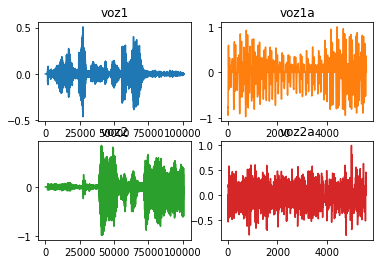

In [141]:
import numpy as np
from matplotlib import pyplot as plt

voz1 = AVB_CVG['edu']#[0:int(TS*TA)]
voz1a = AVB(voz1, TH, TS, TA, "audio")

voz2 = AVB_CVR['edu']#[0:int(TS*TA)]
voz2a = AVB(voz2, TH, TS, TA, "audio")


#Plotando
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(voz1)
axs[0, 0].set_title('voz1')
axs[0, 1].plot(voz1a[1], 'tab:orange')
axs[0, 1].set_title('voz1a')
axs[1, 0].plot(voz2, 'tab:green')
axs[1, 0].set_title('voz2')
axs[1, 1].plot(voz2a[1], 'tab:red')
axs[1, 1].set_title('voz2a')

In [155]:
print(np.amax(AVB_CVG['edu']), np.amax(AVB_CVR['edu']))

0.060699463 0.46569824
